In [1]:
#make JAX recognise multiple CPU cores
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'
PATH = os.getenv('PATH')
%env PATH=/home/juehang/.conda/envs/numpyro_gpu/bin:$PATH

env: PATH=/home/juehang/.conda/envs/numpyro_gpu/bin:/opt/conda/envs/jupyterhub/bin:/opt/conda/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [2]:
from functools import partial
import numpy as np
import scipy.stats as spystats
import corner
import arviz as az
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# JAX imports
import jax
from jax import config, jit, lax, random
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.scipy import stats
from jax.scipy.special import ndtri, erf, gammaln, ndtr

# Numpyro and related imports
import numpyro
from numpyro.infer.reparam import LocScaleReparam
from numpyro import infer
import numpyro.distributions as ndist

# Tensorflow Probability (TFP) imports
from tensorflow_probability.substrates import jax as tfp


In [3]:
device_cpu = jax.devices('cpu')[0]
device_gpu = jax.devices('gpu')[0]
jax.config.update("jax_default_device", device_cpu)
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

2023-11-10 20:53:13.400756: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 12652838912


In [4]:
# Global vars
sqrt2 = np.sqrt(2)
inv_sqrt2_PI = np.sqrt(2*jnp.pi)

In [5]:
def DiscreteNormalPs(loc, scale, bin_edges=(jnp.linspace(-0,201,202)-0.5).reshape(-1,1)):
    """
    Computes the probability mass function of a discretized Normal distribution.
    
    This function calculates the difference between the cumulative distribution function (CDF) values at 
    given bin edges and then normalizes these probabilities.

    Parameters:
    loc (float): The mean (mu) of the Normal distribution.
    scale (float): The standard deviation (sigma) of the Normal distribution.
    bin_edges (array_like): The array containing the edges of the bins. Default is an array of shape (202, 1)
                             with values ranging from -0.5 to 200.5.

    Returns:
    array_like: A transposed version of the normalized PDF values corresponding to the given bin edges.
    """

    # Calculate the differences in CDF values for the provided bin edges
    ps = jnp.diff(stats.norm.cdf(bin_edges,loc,scale), axis=0)

    # Obtain the machine limits for floating point types
    finfo = jnp.finfo(jnp.result_type(ps, float))

    # Clip the calculated probabilities to avoid underflow or overflow issues
    ps = jnp.clip(ps, a_min=finfo.eps, a_max=1.0 - finfo.eps)

    # Normalize and return the probabilities so that their sum is 1
    return ps.T/jnp.sum(ps)


In [6]:
def DiscreteNormal(loc, scale, validate_args=None):
    """
    Computes the Categorical distribution probabilities using a discretized Normal distribution.

    This function calculates the differences in cumulative distribution function (CDF) values 
    for a provided Normal distribution defined by its mean (loc) and standard deviation (scale). 
    It then uses these probabilities to instantiate a Categorical distribution.

    Parameters:
    loc (float): The mean (mu) of the Normal distribution.
    scale (float): The standard deviation (sigma) of the Normal distribution.
    validate_args (bool, optional): Whether to enable validation of input arguments. 
                                    Default is None, meaning no argument validation.

    Returns:
    Categorical Distribution: A Categorical distribution object instantiated with 
                              the calculated probabilities.
    """
    # Calculate the differences in CDF values for a Normal distribution
    categorical_p_arr = DiscreteNormalPs(loc, scale)

    # Instantiate a Categorical distribution with the calculated probabilities
    return ndist.CategoricalProbs(categorical_p_arr, validate_args=validate_args)


In [7]:
class SkewNormal(ndist.Distribution):
    """
    Implementation of the Skew Normal distribution.

    Attributes
    ----------
    arg_constraints : dict
        A dictionary indicating the constraints for the distribution parameters.
    support : ndist.constraints.real
        The real value support for the distribution.
    reparametrized_params : list
        List of reparametrized parameters.
    loc : scalar or array, optional
        Location parameter, default is 0.0.
    scale : scalar or array, optional
        Scale parameter, default is 1.0.
    skew : scalar or array, optional
        Skew parameter, default is 0.
    validate_args : bool, optional
        If true, distribution parameters are checked for validity despite possibly degrading runtime performance, default is None.

    Methods
    -------
    __init__(self, loc=0.0, scale=1.0, skew=0, *, validate_args=None)
        Constructor method.
    sample(self, key, sample_shape=())
        Draw samples from the distribution.
    log_prob(self, value)
        Compute the log probability density function at a given point.
    cdf(self, value)
        Compute the cumulative distribution function at a given point.
    log_cdf(self, value)
        Compute the log of the cumulative distribution function at a given point.
    mean(self)
        Compute the expected value of the distribution.
    variance(self)
        Compute the variance of the distribution.

    """

    arg_constraints = {"loc": ndist.constraints.real, "scale": ndist.constraints.positive, "skew": ndist.constraints.real}
    support = ndist.constraints.real
    reparametrized_params = ["loc", "scale"]

    def __init__(self, loc=0.0, scale=1.0, skew=0, *, validate_args=None):
        batch_shape = lax.broadcast_shapes(jnp.shape(loc), jnp.shape(scale), jnp.shape(skew))
        self.loc, self.scale, self.skew = ndist.util.promote_shapes(loc, scale, skew, shape=batch_shape)
        self._delta = self.skew/jnp.sqrt(1 + self.skew**2)
        super(SkewNormal, self).__init__(
            batch_shape=batch_shape, validate_args=validate_args
        )

    def sample(self, key, sample_shape=()):
        assert numpyro.util.is_prng_key(key)
        eps = spystats.skewnorm.rvs(
            self.skew, size=sample_shape + self.batch_shape + self.event_shape, random_state=np.random.RandomState(key)
        )
        return self.loc + eps * self.scale

    @ndist.util.validate_sample
    def log_prob(self, value):
        normalize_term = jnp.log(0.5*jnp.sqrt(2 * jnp.pi) * self.scale)
        value_scaled = (value - self.loc) / self.scale
        return -0.5 * value_scaled**2 - normalize_term + stats.norm.logcdf(self.skew*value_scaled)

    def cdf(self, value):
        scaled = (value - self.loc) / self.scale
        return ndtr(scaled) - tfp.math.owens_t(scaled, self.skew)

    def log_cdf(self, value):
        return jnp.log(self.cdf(value))

#     def icdf(self, q):
#         return self.loc + self.scale * ndtri(q)

    @property
    def mean(self):
        return jnp.broadcast_to(self.loc + self.scale*self._delta*jnp.sqrt(2/jnp.pi), self.batch_shape)

    @property
    def variance(self):
        return jnp.broadcast_to(self.scale**2*(1 - 2*self._delta**2/jnp.pi), self.batch_shape)

In [8]:
def DiscreteSkewNormalPs(loc, scale, skew, bin_edges=(jnp.linspace(-0,201,202)-0.5).reshape(-1,1)):
    """
    Computes the probability mass function (pmf) for a discretized version of the Skew Normal distribution.

    Parameters
    ----------
    loc : scalar or array
        Location parameter of the Skew Normal distribution.
    scale : scalar or array
        Scale parameter of the Skew Normal distribution.
    skew : scalar or array
        Skew parameter of the Skew Normal distribution.
    bin_edges : array, optional
        The bin edges for the discretization of the Skew Normal distribution. 
        Default is a linspace from -0 to 201 with 202 points reshaped into a column vector.

    Returns
    -------
    ps : array
        The pmf values corresponding to each bin edge, normalized such that the sum across all bins is 1.

    Notes
    -----
    This function works by first creating a Skew Normal distribution with the given parameters. 
    Then it computes the cumulative distribution function (cdf) at each bin edge, and takes the differences 
    to find the probability mass in each bin. The resulting pmf is then normalized so that its total mass is 1.

    """

    skew_normal = SkewNormal(loc, scale, skew)
    ps = jnp.diff(skew_normal.cdf(bin_edges), axis=0)
    finfo = jnp.finfo(jnp.result_type(ps, float))
    ps = jnp.clip(ps, a_min=finfo.eps, a_max=1.0 - finfo.eps)
    return ps.T/jnp.sum(ps)

In [9]:
ndist.LeftTruncatedDistribution.supported_types + (1,)

(numpyro.distributions.continuous.Cauchy,
 numpyro.distributions.continuous.Laplace,
 numpyro.distributions.continuous.Logistic,
 numpyro.distributions.continuous.Normal,
 numpyro.distributions.continuous.SoftLaplace,
 numpyro.distributions.continuous.StudentT,
 1)

In [10]:
class CustomLeftTruncatedDistribution(ndist.LeftTruncatedDistribution):
    supported_types = ndist.LeftTruncatedDistribution.supported_types + (SkewNormal,)

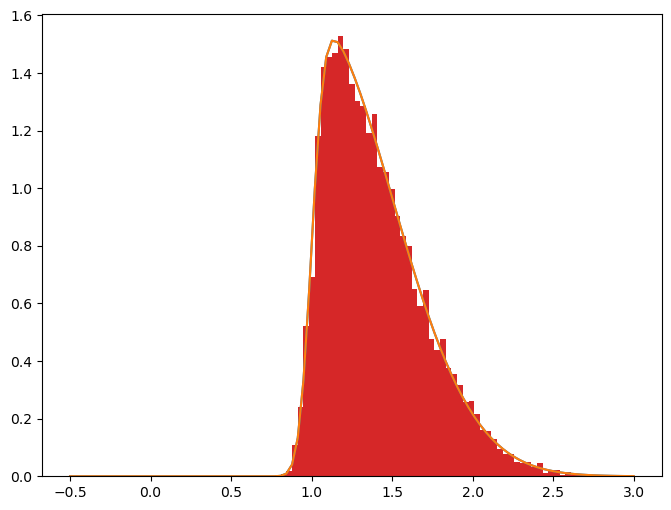

In [11]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
x_plot = np.linspace(-0.5,3, 100)
spstat_rv = spystats.skewnorm(8, 1, 0.5)
my_rv = SkewNormal(1, 0.5, 8)
ax.plot(x_plot, jnp.exp(spstat_rv.logpdf(x_plot)))
ax.plot(x_plot, jnp.exp(my_rv.log_prob(x_plot)))
ax.hist(my_rv.sample(jax.random.PRNGKey(42), sample_shape=(10000,)), density=True, bins=x_plot)
ax.hist((SkewNormal(0, 1, 8).sample(jax.random.PRNGKey(42), sample_shape=(10000,))*0.5+1), density=True, bins=x_plot)
plt.show()

In [12]:
@jit
def fano_ER(mean_N_q, E_field, density):
    """
    Calculates the a Fano-like factor to determine the variance of quanta generation.

    Parameters
    ----------
    mean_N_q : scalar or array
        Mean number of quanta produced per event.
    E_field : scalar or array
        Electric field strength in the detector.
    density : scalar or array
        Density of the detector material.

    Returns
    -------
    Fano factor : scalar or array
        The calculated Fano factor based on the input parameters.
    
    """

    return (0.13 - 0.030*density - 0.0057*density**2 + 0.0016*density**3 + 0.0015*jnp.sqrt(mean_N_q*E_field))

In [13]:
def get_yields_beta(E, density, exciton_ion_ratio, W, m01=7.096208, m02=77.2931084, m03=0.7155229, m04=1.8279102, m07=94.39740941928082, m08=4.285781736, m09=0.3344049589, m10=0.06623858):
    """
    Calculates the yields of quanta, electrons and photons for beta radiation in a detector.

    Parameters
    ----------
    E : scalar or array
        Energy of the incident beta radiation.
    density : scalar or array
        Density of the detector material.
    exciton_ion_ratio : scalar
        Ratio of excitons to ions produced in the detector.
    W : scalar
        Average energy required to produce an electron-ion pair.
    m01, m02, m03, m04, m07, m08, m09, m10 : scalars
        Parameter values used in the empirical formula for calculating yields.

    Returns
    -------
    mean_N_q : scalar or array
        Mean number of quanta produced per event.
    Ne : scalar or array
        Number of electrons produced.
    Nph : scalar or array
        Number of photons produced.

    Notes
    -----
    This function calculates the yields of quanta, electrons and photons produced by beta radiation 
    in LXe based on the energy of the incident radiation, the density of the detector material, 
    and the ratio of excitons to ions produced.
    """

    m05 = 1/W/(1 + exciton_ion_ratio) - m01
    Qy = m01 + (m02 - m01) / ((1. + (E / m03)**m04))**m09 + m05 + (0.0 - m05) / ((1. + (E / m07)**m08))**m10
    mean_N_q = E/W*1e3
    Ly = mean_N_q / E - Qy
    Ne = Qy * E
    Nph = Ly * E
    return mean_N_q, Ne, Nph

In [14]:
def Nei_ratio(E, density):
    """
    Calculates the ratio of the number of electrons to ions for a given energy and material density.

    Parameters
    ----------
    E : scalar or array
        Energy of the incident radiation.
    density : scalar or array
        Density of the detector material.

    Returns
    -------
    Nei_ratio : scalar or array
        The ratio of the number of electrons to ions.

    Notes
    -----
    This function calculates the ratio of the number of electrons to ions produced by 
    ERs.
    """

    return (0.067366 + 0.039693*density)*erf(0.05*E)

In [15]:
def CategoricalBinomRound(counts, p, max_count=1000):
    binom_ps = ndist.Binomial(jnp.floor(counts.reshape(-1,1)).astype(int), p.reshape(-1,1)).log_prob(jnp.arange(max_count).reshape(1,-1))
    return ndist.CategoricalLogits(binom_ps)

In [16]:
def recom_omega_ER(E_field, elecFrac, width_param_7=0.046452, width_param_8=0.205, width_param_9=0.45, width_param_10=-0.2):
    '''
    This function calculates the omega parameter for electron recoil (ER) events based on certain input parameters.
    
    Parameters
    ----------
    E_field : float 
        The electric field value.
    elecFrac : float 
        The fraction of energy deposited by electrons.
    width_param_7 : float, optional 
        Parameter A from Table VI of https://arxiv.org/pdf/2211.10726.pdf; default is 0.046452.
    width_param_8 : float, optional 
        Omega parameter from Table VI of https://arxiv.org/pdf/2211.10726.pdf; default is 0.205.
    width_param_9 : float, optional 
        Xi parameter from Table VI of https://arxiv.org/pdf/2211.10726.pdf; default is 0.45.
    width_param_10 : float, optional 
        Skewness parameter; default is -0.2.

    Returns
    -------
    omega : float 
        The calculated omega parameter for ER events.
    width_param_10 : float 
        The skewness parameter.

    Notes
    -----
    The function uses the provided parameters to calculate the value of omega for ER events. It also returns the skewness parameter.
    '''
    A = 0.086036 + (width_param_7 - 0.086036) / (1 + (E_field/295.2)**251.6)**0.0069114
    wide = width_param_8
    cntr = width_param_9
    skew = width_param_10
    mode = cntr + 2 * (1/inv_sqrt2_PI) * skew * wide / jnp.sqrt(1. + skew * skew)
    norm = 1. / (jnp.exp(-0.5 * (mode - cntr)**2 / (wide * wide)) * (1. + erf(skew * (mode - cntr) / (wide * sqrt2))))
    omega = norm * A * jnp.exp(-0.5 * (elecFrac - cntr)**2 / (wide * wide)) * (1. + erf(skew * (elecFrac - cntr) / (wide * sqrt2)))
    return omega, width_param_10


In [17]:
recom_omega_ER(23, 0.5)

(Array(0.0428016, dtype=float64), -0.2)

In [18]:
def simple_ER_model(data_S1, data_S2, data_len, E_field=23, W=13.7, density=2.8619):
    '''
    This function is a simple model for Electron Recoil (ER) using parameters such as electric field, work function and density.

    Parameters
    ----------
    data_S1 : array-like
        An array of observed S1 values.
    data_S2 : array-like
        An array of observed S2 values.
    data_len : int
        The length of the data.
    E_field : float, optional
        The electric field value; default is 23.
    W : float, optional
        The work function defined in eV; default is 13.7.
    density : float, optional
        The density of the medium defined in g/cm^3; default is 2.8619.

    Notes
    -----
    The function uses numpyro to define a probabilistic model for ER event simulation. It assumes specific distributions for various parameters like energy, 
    number of quanta, ionization, excitation and scintillation based on physical principles. Beta distributions are used to approximate binomial distributions.
    '''

    # Define some constants
    g1 = 0.105
    g2 = 17.3
    SE_gain = 31.8

    # Calculate extraction efficiency
    extraction_eff = g2/SE_gain
    
    PMT_sigma = 0.8
    S2_sigma = numpyro.sample('S2_sigma', ndist.Normal(27, 1))
    
    with numpyro.plate('data', data_len) as ind:
        n_data = len(ind)

        # Sample energy from uniform distribution
        E = numpyro.sample('E', ndist.Uniform(0, 100))

        # Get yields
        exciton_ion_ratio = Nei_ratio(E, density)
        mean_N_q, mean_Ne, mean_Nph = get_yields_beta(E, density, exciton_ion_ratio, W)

        Nq_scaled = numpyro.sample('Nq_scaled', ndist.TruncatedNormal(1, jnp.sqrt(fano_ER(mean_N_q, E_field, density)/mean_N_q), low=0))
        Nq = Nq_scaled*mean_N_q

        # Calculate number of ions and excitations
        alf = 1/(1 + exciton_ion_ratio)
        beta_dist_a = Nq*alf
        beta_dist_b = Nq*(1-alf)
        Ni_p = numpyro.sample('Ni_p', ndist.Beta(beta_dist_a, beta_dist_b))
        Ni = Ni_p*Nq
        Nex = Nq - Ni
        
        e_frac = mean_Ne/mean_N_q
        recombProb = 1. - (exciton_ion_ratio + 1.) * e_frac
        recomb_omega, skewness = recom_omega_ER(23, e_frac)

        # Calculate recombination variance
        recomb_variance = recombProb*(1 - recombProb)*Ni + (recomb_omega*Ni)**2
        
        widthCorrection = jnp.sqrt(1. - (2. / jnp.pi) * skewness * skewness / (1. + skewness * skewness))
        muCorrection = (jnp.sqrt(recomb_variance) / widthCorrection) * (skewness / jnp.sqrt(1. + skewness * skewness)) * 2. * inv_sqrt2_PI
        
        Ne_mu = (1. - recombProb) * Ni - muCorrection
        Ne_sigma = jnp.sqrt(recomb_variance) / widthCorrection

        Ne_scaled = numpyro.sample('Ne',  CustomLeftTruncatedDistribution(SkewNormal(1, Ne_sigma/Ne_mu, skewness)))
        Ne = Ne_scaled*Ne_mu

        Nph = Nq - Ne
        
        # Calculate S1 and S2 signals
        beta_dist_a = Nph*g1
        beta_dist_b = Nph*(1-g1)
        S1_p = numpyro.sample('S1_p', ndist.Beta(beta_dist_a, beta_dist_b))
        S1 = numpyro.sample('S1', ndist.Normal(S1_p*Nph, jnp.sqrt(S1_p*jnp.abs(Nph))*PMT_sigma), obs=data_S1)

        beta_dist_a = Ne*extraction_eff
        beta_dist_b = Ne*(1-extraction_eff)
        S2_p = numpyro.sample('S2_p', ndist.Beta(beta_dist_a, beta_dist_b))
        S2 = numpyro.sample('S2', ndist.Normal(S2_p*Ne*SE_gain, jnp.sqrt(S2_p*jnp.abs(Ne))*S2_sigma), obs=data_S2)


In [19]:
#generate some simulated data using nestpy

import nestpy
detector = nestpy.VDetector()

In [20]:
A = 131.293 # avg atomic mass of Xe
Z = 54. # Atomic number of Xe 

nc = nestpy.NESTcalc(detector)

density = nc.GetDensity( T=detector.get_T_Kelvin(), P=detector.get_p_bar(), inGas=False )
print( "Using detector's LXe density, %.3f g/cc" % density)

Using detector's LXe density, 2.861 g/cc


In [21]:
@np.vectorize
def GetQuanta(interaction=nestpy.beta, 
              energy=100., # energy in keV of the recoil itself
              drift_field=81.): # V/cm
    
    #What's first done in nestpy is getting the yields 
    #Based on the arguments below; most important, energy, density, field.
    #To see the spectrum of these, see nest.ucdavis.edu/benchmarkplots 
    y = nc.GetYields(interaction,
     energy,
     density,
     drift_field,
     A,
     Z,
    ) 
    # Then we call nestcalc class' function, GetQuanta 
    quanta = nc.GetQuanta(y, density)
    photons, electrons = quanta.photons, quanta.electrons

    return photons, electrons

In [22]:
test_E = np.random.uniform(2,50,50)
g1 = 0.105
g2 = 17.3
SE_gain = 31.8
extraction_eff = g2/SE_gain
PMT_sigma = 0.8
S2_sigma=26

In [23]:
Nph_nest, Ne_nest = GetQuanta(energy=test_E)
# Nq_nest = Ne_nest + Nph_nest
Nph_det_nest = spystats.binom.rvs(Nph_nest, g1)
S1_nest = spystats.norm.rvs(Nph_det_nest, jnp.sqrt(Nph_det_nest)*PMT_sigma)

Ne_det_nest = spystats.binom.rvs(Ne_nest, extraction_eff)
S2_nest = spystats.norm.rvs(Ne_det_nest*SE_gain, jnp.sqrt(Ne_det_nest)*S2_sigma)

# S2_nest = spystats.norm.rvs(Ne_nest*g2, Ne_nest/10)

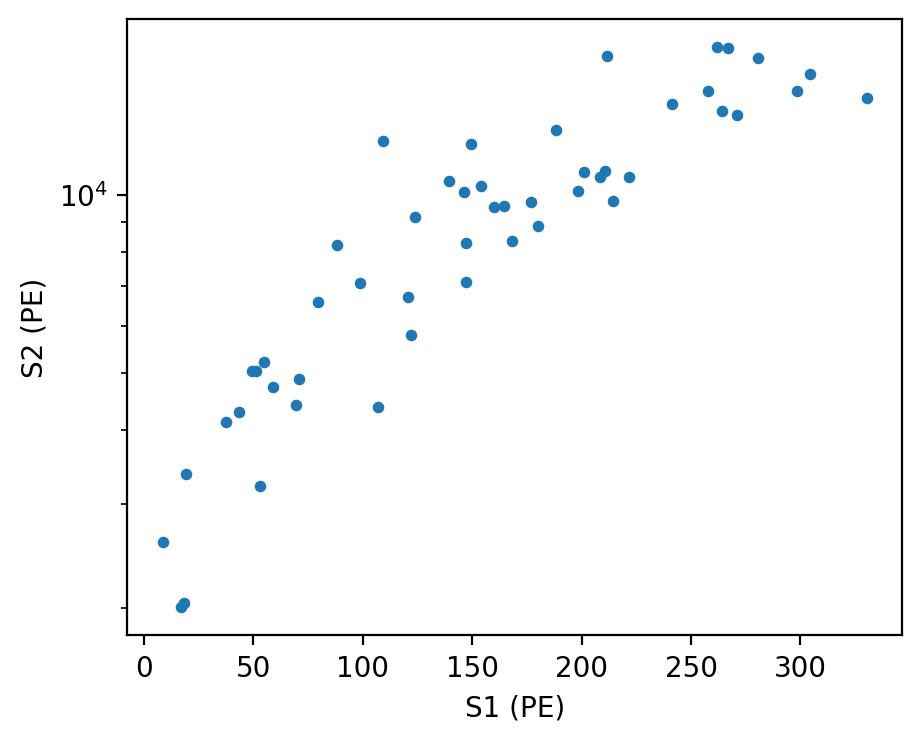

In [24]:
#plot simulated data

fig = plt.figure(figsize=(5,4), dpi=200)
ax = fig.add_subplot(111)
ax.scatter(S1_nest, S2_nest, s=10)
ax.set(yscale='log', xlabel='S1 (PE)', ylabel='S2 (PE)')
plt.show()

In [25]:
config = {
    # "Nq": LocScaleReparam(centered=0),
    "S2_sigma": LocScaleReparam(centered=0)
}
rep_simple_ER_model = numpyro.handlers.reparam(simple_ER_model, config=config)

In [26]:
kernel = infer.NUTS(
    rep_simple_ER_model, 
    target_accept_prob=0.5, 
    max_tree_depth=11, 
    init_strategy=infer.init_to_median(num_samples=15)
)

mcmc_sampler = infer.MCMC(kernel, num_warmup=900, num_samples=500, progress_bar=True, num_chains=3)
mcmc_sampler.run(jax.random.PRNGKey(42), S1_nest, S2_nest, len(S1_nest))

  0%|          | 0/1400 [00:00<?, ?it/s]

  0%|          | 0/1400 [00:00<?, ?it/s]

  0%|          | 0/1400 [00:00<?, ?it/s]

In [27]:
test_E

array([36.20711464, 25.68112578, 31.6268629 , 49.84800374, 37.37922247,
       10.79852663, 44.65946809, 24.76147012, 15.78003464, 19.40888396,
       12.01861292,  3.62239248, 29.42285986, 37.37864502, 26.5314455 ,
       26.49410875, 10.95581945,  4.55230183,  8.18630256, 16.50808671,
       43.47938631, 36.64899961, 37.34857374, 25.82897954, 22.53954344,
       28.57216618, 45.257065  , 34.7248193 , 29.74544455, 36.31173385,
       11.91374176, 22.87894854, 11.33780288, 10.68404326,  4.17989369,
       47.28273562, 42.77160595, 30.38357243,  8.10132566, 47.4850709 ,
       16.93124221, 20.947029  , 48.40590259, 11.76129242, 47.76502859,
        4.54504017, 25.24569005, 47.76770808, 31.7620669 , 13.04554636])

In [28]:
inf_data = az.from_numpyro(mcmc_sampler)
az.summary(inf_data, round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
E[0],36.2641,2.3528,31.8030,40.5131,0.0467,0.0334,2549.0941,1044.9272,1.0025
E[1],29.5485,2.0413,25.3723,33.0498,0.0460,0.0325,1962.6557,1158.4798,0.9997
E[2],31.7939,2.1632,27.8305,35.7178,0.0418,0.0299,2717.2345,1018.9707,0.9994
E[3],52.7200,2.9287,47.4281,58.3171,0.0596,0.0423,2420.5433,1037.2929,1.0011
E[4],38.3084,2.3971,34.0158,42.8138,0.0509,0.0360,2223.1408,1279.8760,0.9999
...,...,...,...,...,...,...,...,...,...
S2_p[47],0.5584,0.0158,0.5264,0.5857,0.0003,0.0002,3129.7559,1274.9376,1.0028
S2_p[48],0.5502,0.0196,0.5138,0.5851,0.0004,0.0002,3063.5730,1072.4473,1.0016
S2_p[49],0.5563,0.0250,0.5138,0.6054,0.0004,0.0003,3459.8483,1048.2838,0.9990
S2_sigma,27.6766,1.0166,25.8720,29.5472,0.0208,0.0147,2424.6379,1091.9859,1.0029


In [29]:
mcmc_sampler.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
                 E[0]     36.26      2.35     36.25     32.39     40.13   2672.92      1.00
                 E[1]     29.55      2.04     29.52     26.05     32.71   1913.24      1.00
                 E[2]     31.79      2.16     31.75     28.23     35.08   2563.12      1.00
                 E[3]     52.72      2.93     52.67     47.83     57.44   2401.19      1.00
                 E[4]     38.31      2.40     38.36     34.30     42.07   2089.28      1.00
                 E[5]      9.43      1.15      9.38      7.53     11.34   2644.97      1.00
                 E[6]     51.92      2.67     51.85     47.65     56.29   2711.30      1.00
                 E[7]     28.74      2.01     28.66     25.61     31.99   2114.14      1.00
                 E[8]     16.92      1.54     16.86     14.47     19.43   2163.91      1.00
                 E[9]     21.30      1.76     21.26     18.49     24.18   2599.

In [30]:
inf_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [31]:
np.median(inf_data['posterior']['E'][0,:,0])

36.175499531242934

In [32]:
np.median(inf_data['posterior']['E'][1,:,0])

36.25142236418861

In [33]:
np.median(inf_data['posterior']['E'][2,:,0])

36.30101193773284

In [34]:
inf_data['log_likelihood']['S2']

<xarray.DataArray 'S2' (chain: 3, draw: 500, S2_dim_0: 50)>
array([[[ -7.6189073 ,  -7.261631  ,  -7.30808408, ...,  -7.55100992,
          -7.90041857,  -7.7981849 ],
        [ -7.17673619,  -7.50436595, -11.05606566, ...,  -8.30417345,
          -8.4740352 ,  -7.07694697],
        [ -7.67336915,  -7.81743734,  -8.65836808, ...,  -8.2492334 ,
          -7.41933706,  -7.95308015],
        ...,
        [ -7.14621347,  -7.2181626 ,  -7.88021111, ...,  -9.16870465,
          -7.06008933,  -6.85740667],
        [ -7.30492214,  -7.11447525,  -9.64180408, ...,  -7.39181334,
          -7.24059417,  -7.1670824 ],
        [ -7.11183137,  -7.44822628,  -8.53019143, ...,  -9.5896171 ,
          -7.88305192,  -7.0071884 ]],

       [[ -7.11712579,  -7.25106218,  -8.65278398, ...,  -7.37620923,
          -7.36444558,  -6.91814921],
        [ -7.0730241 ,  -7.22871704,  -7.22502841, ...,  -7.36243971,
         -12.50877046,  -6.89728933],
        [ -7.27047761,  -7.19963413,  -7.36460735, ...,  -7.97884789,
          -7.23787747,  -7.01224659],
...
        [ -7.07851872,  -7.58020338,  -9.15701572, ...,  -8.67283704,
          -7.41549928,  -7.26424481],
        [ -7.84872904,  -7.49305474,  -8.17498231, ...,  -7.87346073,
          -7.20101992, -11.03318787],
        [ -7.92263754,  -7.89274838, -10.52426717, ...,  -7.62297375,
          -7.17506939,  -7.5599496 ]],

       [[ -8.37626598,  -9.05544849,  -7.40369045, ...,  -7.54837467,
          -7.59527708,  -6.89798007],
        [ -7.26295579,  -8.20953015,  -7.38506677, ...,  -7.47668687,
          -7.57608942,  -6.94642933],
        [ -7.3837079 ,  -7.31418141,  -9.6850073 , ...,  -9.43484937,
          -7.30791756,  -8.92248538],
        ...,
        [ -7.43762649,  -8.57066031,  -7.5215107 , ..., -10.09670588,
          -7.13855244,  -7.1022411 ],
        [ -7.22346202,  -8.559305  , -10.54422393, ...,  -8.29273903,
          -7.29407133,  -7.09677176],
        [ -7.50558456,  -7.20215362,  -7.8072566 , ...,  -7.91197398,
          -8.47057215,  -6.93414276]]])
Coordinates:
  * chain     (chain) int64 0 1 2
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * S2_dim_0  (S2_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49

In [35]:
inf_data['posterior']['Ne']

<xarray.DataArray 'Ne' (chain: 3, draw: 500, Ne_dim_0: 50)>
array([[[1.07966507, 1.18431447, 1.2968313 , ..., 1.2955319 ,
         1.13979256, 1.15130016],
        [1.08666229, 1.17216108, 1.24818244, ..., 1.25749072,
         1.01114508, 1.14281875],
        [0.9737216 , 1.03165237, 1.34639166, ..., 1.22845447,
         1.06866959, 1.17163534],
        ...,
        [1.1173895 , 1.1462359 , 1.36302925, ..., 1.23827068,
         1.09200861, 1.26710898],
        [1.01292723, 1.07924137, 1.27929904, ..., 1.2532785 ,
         1.20175035, 1.12645473],
        [1.05015039, 1.20565249, 1.21418585, ..., 1.31562177,
         1.02223803, 1.13890609]],

       [[1.08694462, 1.17421386, 1.25581147, ..., 1.36198713,
         1.0682161 , 1.12735879],
        [0.95935456, 1.15713241, 1.32543837, ..., 1.195341  ,
         0.98478246, 1.18761274],
        [1.10667907, 1.10548734, 1.26774885, ..., 1.34181959,
         1.17496693, 1.0614823 ],
...
        [1.03722968, 1.14871586, 1.35059916, ..., 1.1890947 ,
         0.98897499, 1.22365204],
        [1.07839584, 1.07815979, 1.31287857, ..., 1.39588937,
         1.13712677, 1.0345602 ],
        [1.01939456, 1.18453552, 1.21608848, ..., 1.2383714 ,
         1.09416611, 1.18859008]],

       [[0.97407215, 1.10364036, 1.33561822, ..., 1.22952909,
         1.09756375, 1.26426646],
        [0.99364211, 1.10336715, 1.35758179, ..., 1.22658108,
         1.08371254, 1.28058104],
        [1.01596006, 1.1023752 , 1.21701926, ..., 1.12723452,
         1.04925535, 1.03685419],
        ...,
        [1.07656422, 1.01868584, 1.41844781, ..., 1.17360935,
         1.08631727, 1.1086454 ],
        [1.02463634, 1.12603365, 1.12605052, ..., 1.34116776,
         1.07875853, 1.12002656],
        [1.02687429, 1.09537531, 1.23310466, ..., 1.274288  ,
         1.01964002, 1.14959981]]])
Coordinates:
  * chain     (chain) int64 0 1 2
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * Ne_dim_0  (Ne_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49

In [36]:
az.summary(inf_data, round_to=4, var_names=['Ne'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ne[0],1.0260,0.0580,0.9139,1.1294,0.0011,0.0008,2761.6259,1179.2806,0.9998
Ne[1],1.1183,0.0654,0.9887,1.2334,0.0014,0.0010,2310.9228,1169.3358,0.9999
Ne[2],1.2899,0.0663,1.1677,1.4197,0.0013,0.0009,2658.1704,862.5463,1.0014
Ne[3],1.1656,0.0577,1.0497,1.2703,0.0012,0.0008,2318.7743,1335.8811,1.0013
Ne[4],1.0662,0.0597,0.9621,1.1772,0.0012,0.0009,2464.4783,1266.0641,1.0005
Ne[5],1.0465,0.0793,0.8943,1.1911,0.0017,0.0012,2039.2511,982.1018,0.9997
Ne[6],1.3403,0.0590,1.2335,1.4541,0.0012,0.0008,2429.6054,1307.8916,0.9994
Ne[7],1.1808,0.0635,1.0676,1.3025,0.0012,0.0009,2658.3270,1326.6817,1.0006
Ne[8],0.8366,0.0665,0.7195,0.9662,0.0012,0.0008,3119.4205,1272.5502,1.0018
Ne[9],1.0103,0.0693,0.8841,1.1413,0.0013,0.0009,2933.2487,1542.2197,1.0002


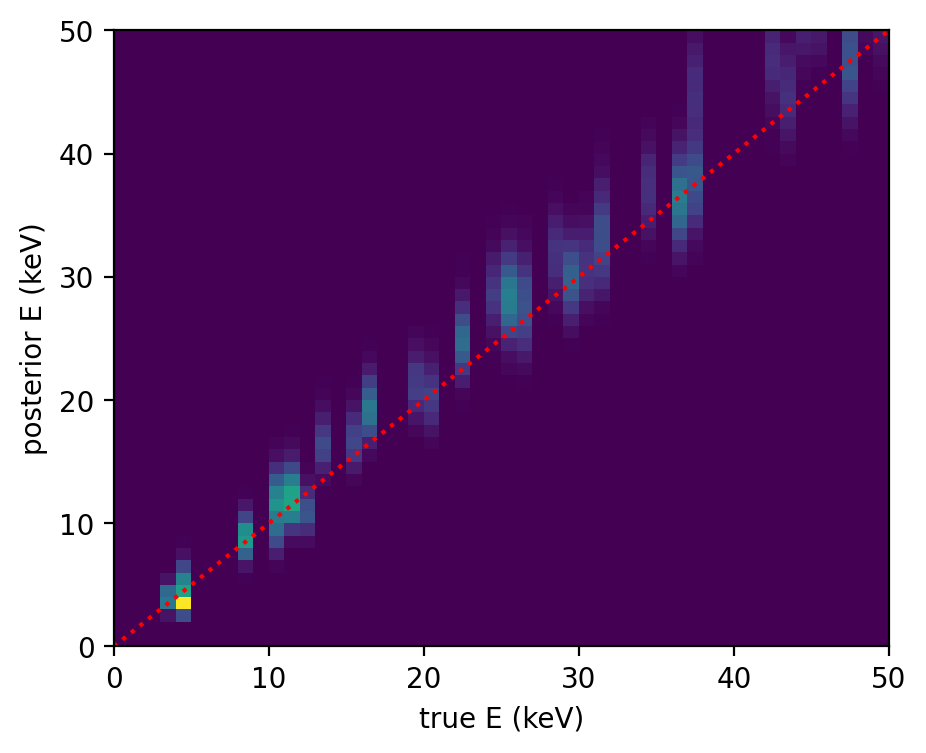

In [37]:
fig = plt.figure(figsize=(5,4), dpi=200)
ax = fig.add_subplot(111)
# ax.scatter(np.repeat(test_E, 1500), np.concatenate(inf_data['posterior']['E']).T, s=5)
ax.hist2d(np.repeat(test_E, 1500), np.concatenate(inf_data['posterior']['E']).T.reshape(-1), bins=np.linspace(0,50,51))
ax.plot([0,50], [0,50], color='r', linestyle=':')
ax.set(xlabel='true E (keV)', ylabel='posterior E (keV)', xlim=[0,50], ylim=[0,50])
plt.show()

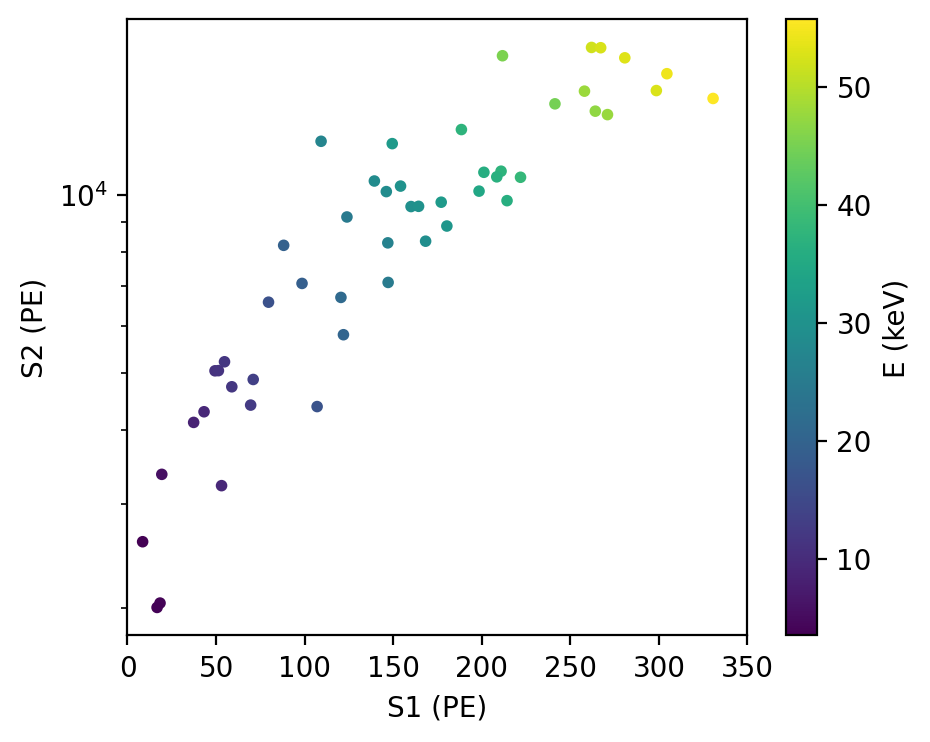

In [38]:
fig = plt.figure(figsize=(5,4), dpi=200)
ax = fig.add_subplot(111)
s = ax.scatter(S1_nest, S2_nest, c=jnp.median(np.concatenate(inf_data['posterior']['E']), axis=0), s=10)
ax.set(yscale='log', xlim=[0, 350], xlabel='S1 (PE)', ylabel='S2 (PE)')
plt.colorbar(s, label='E (keV)')
plt.show()

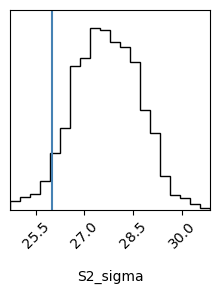

In [39]:
corner.corner(inf_data, var_names=['S2_sigma'], truths=[S2_sigma]);

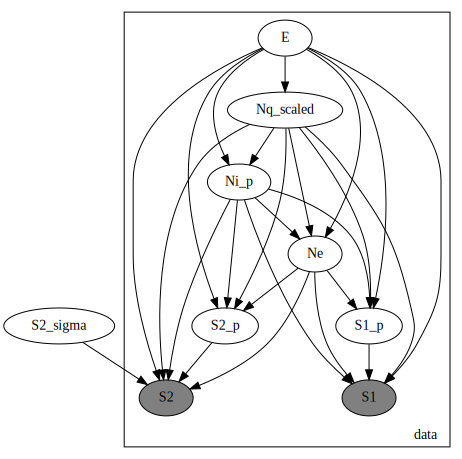

In [40]:
numpyro.render_model(simple_ER_model, model_args=(S1_nest, S2_nest, len(S1_nest)))

/home/juehang/.conda/envs/numpyro_gpu/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='Ne\n1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Ni_p\n1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Nq_scaled\n1'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='S1_p\n1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='S2_p\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='S2_p\n1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='S2_p\n2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E\n1', ylabel='S2_p\n3'>, <Axes: xlabel='Ne\n1'>,
        <Axes: xlabel='Ni_p\n1'>, <Axes: xlabel='Nq_scaled\n1'>,
        <Axes: xlabel='S1_p\n1'>, <Axes: xlabel='S2_p\n0'>,
        

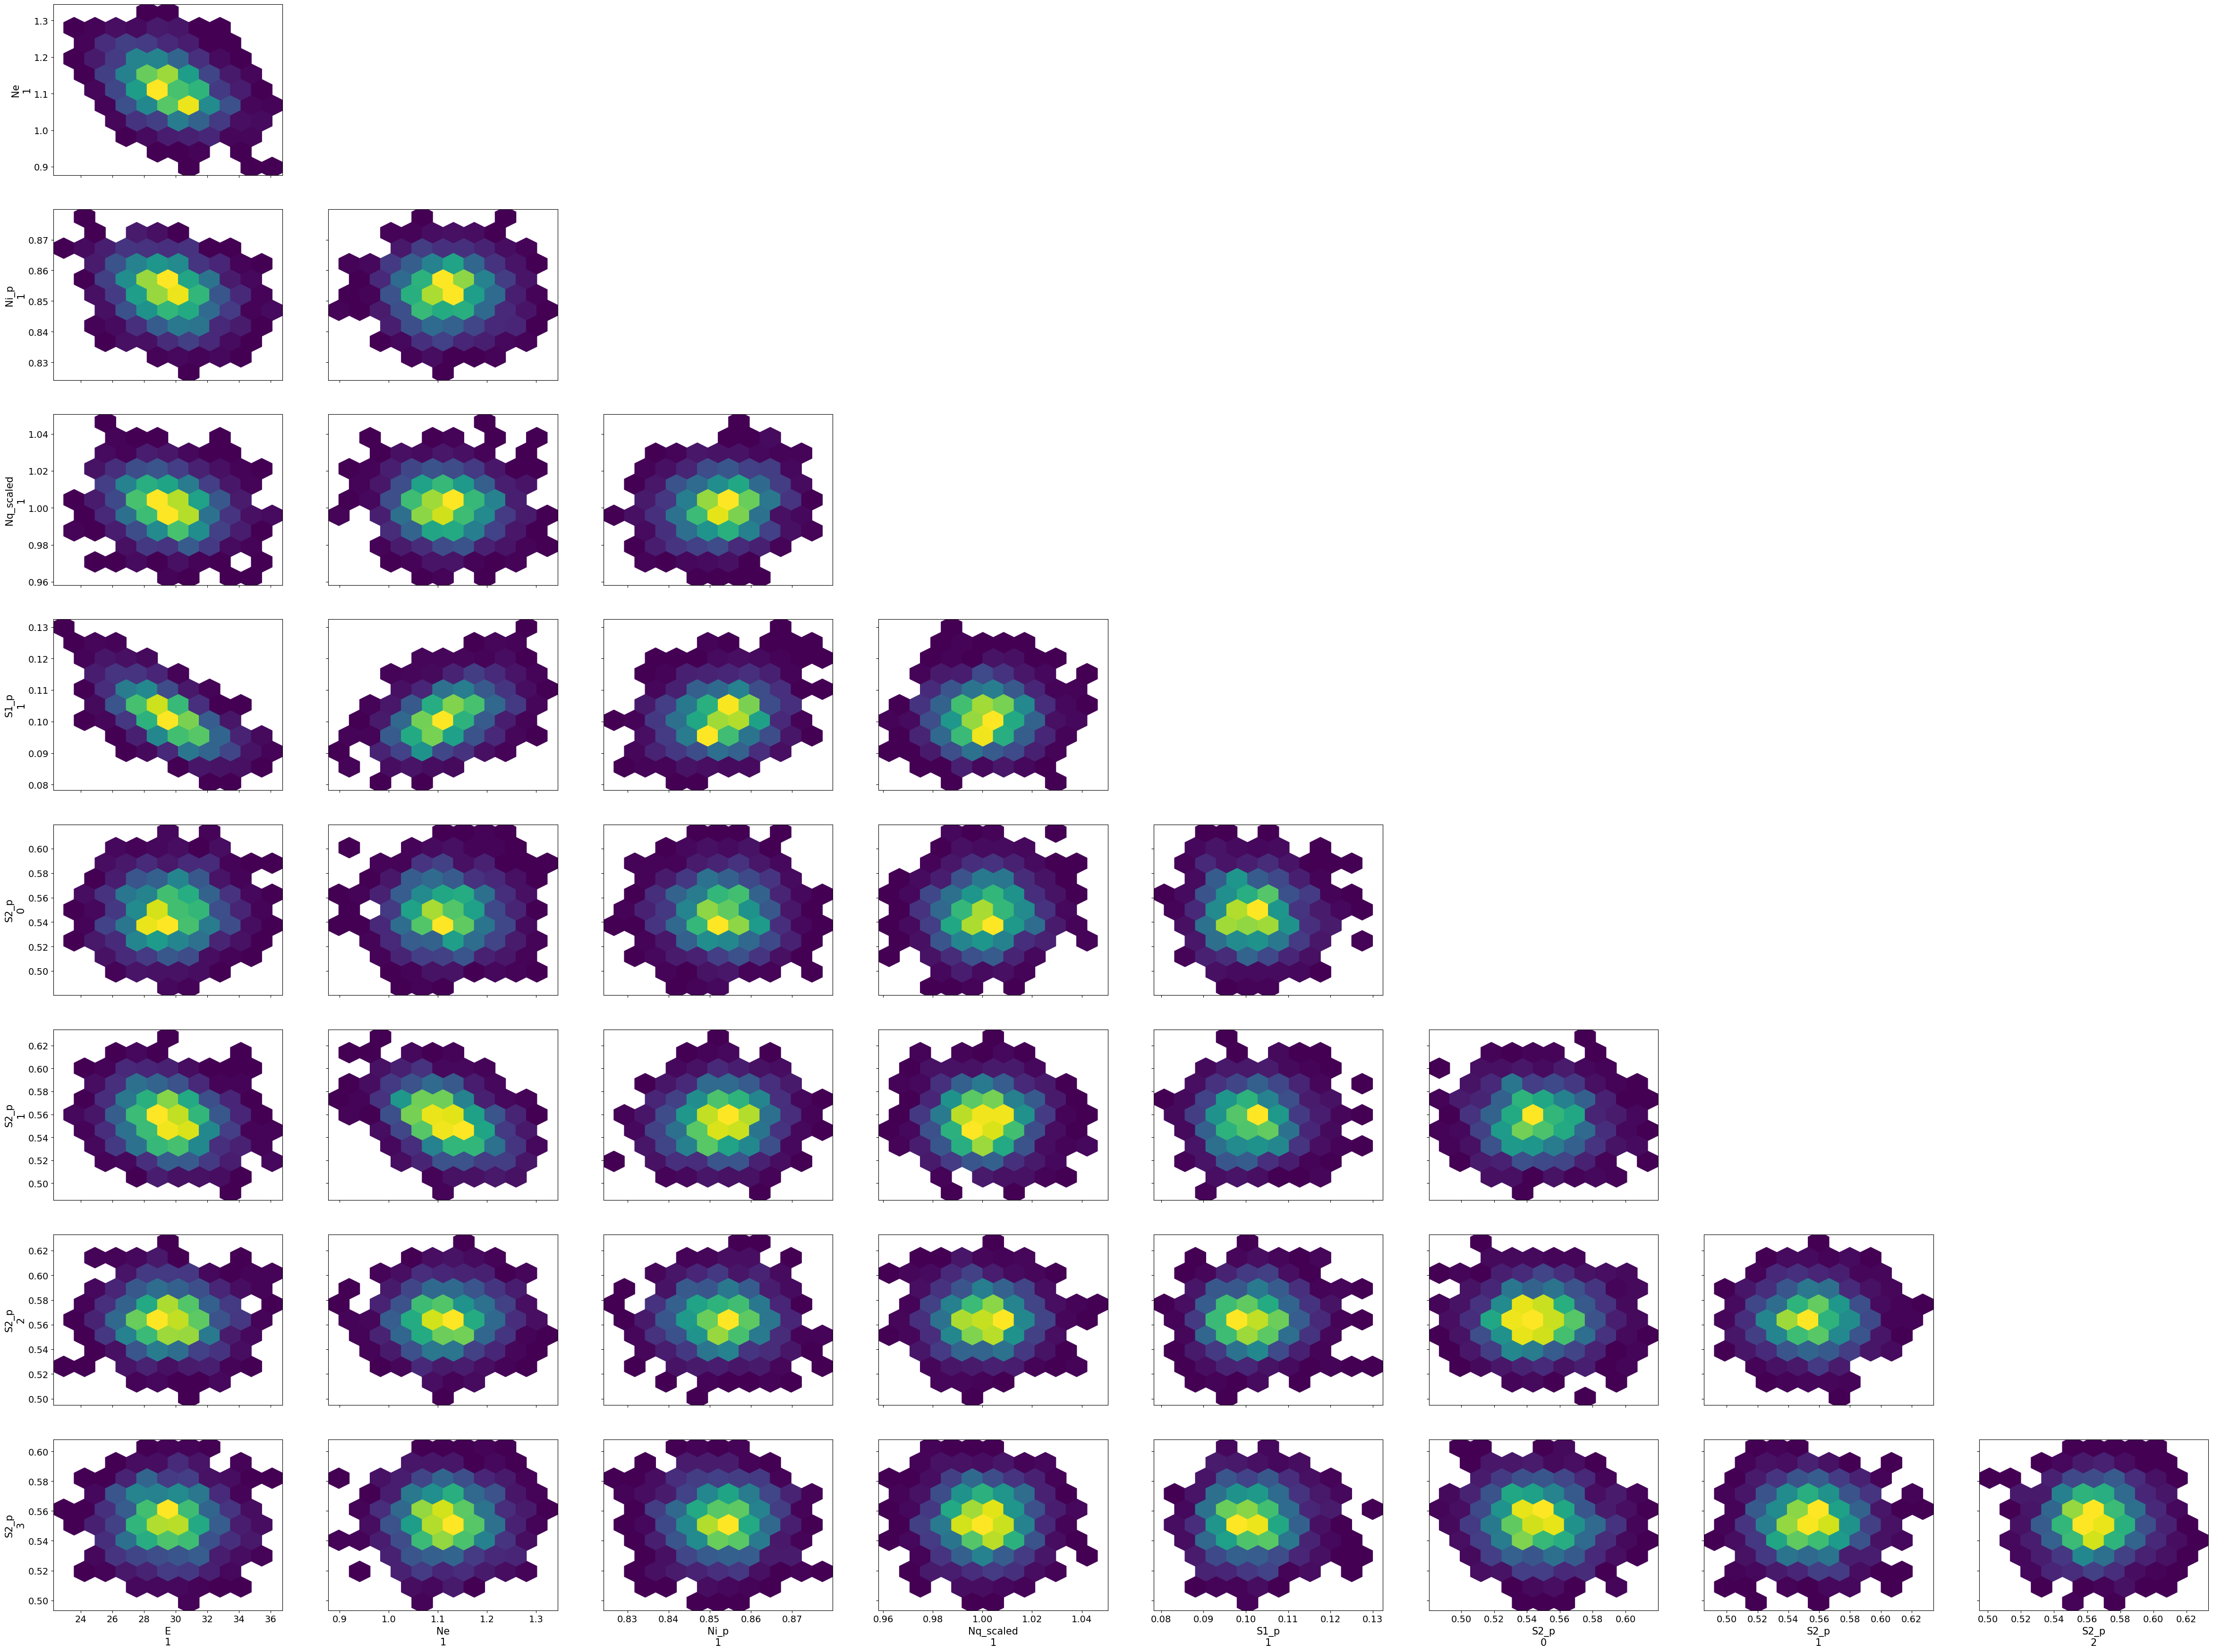

In [41]:
az.plot_pair(inf_data, coords={'Ne_dim_0': [1], 'Nq_scaled_dim_0': [1], 'E_dim_0': [1], 'Ni_p_dim_0': [1], 'S1_p_dim_0': [1]}, kind='hexbin', gridsize=10, divergences=True)

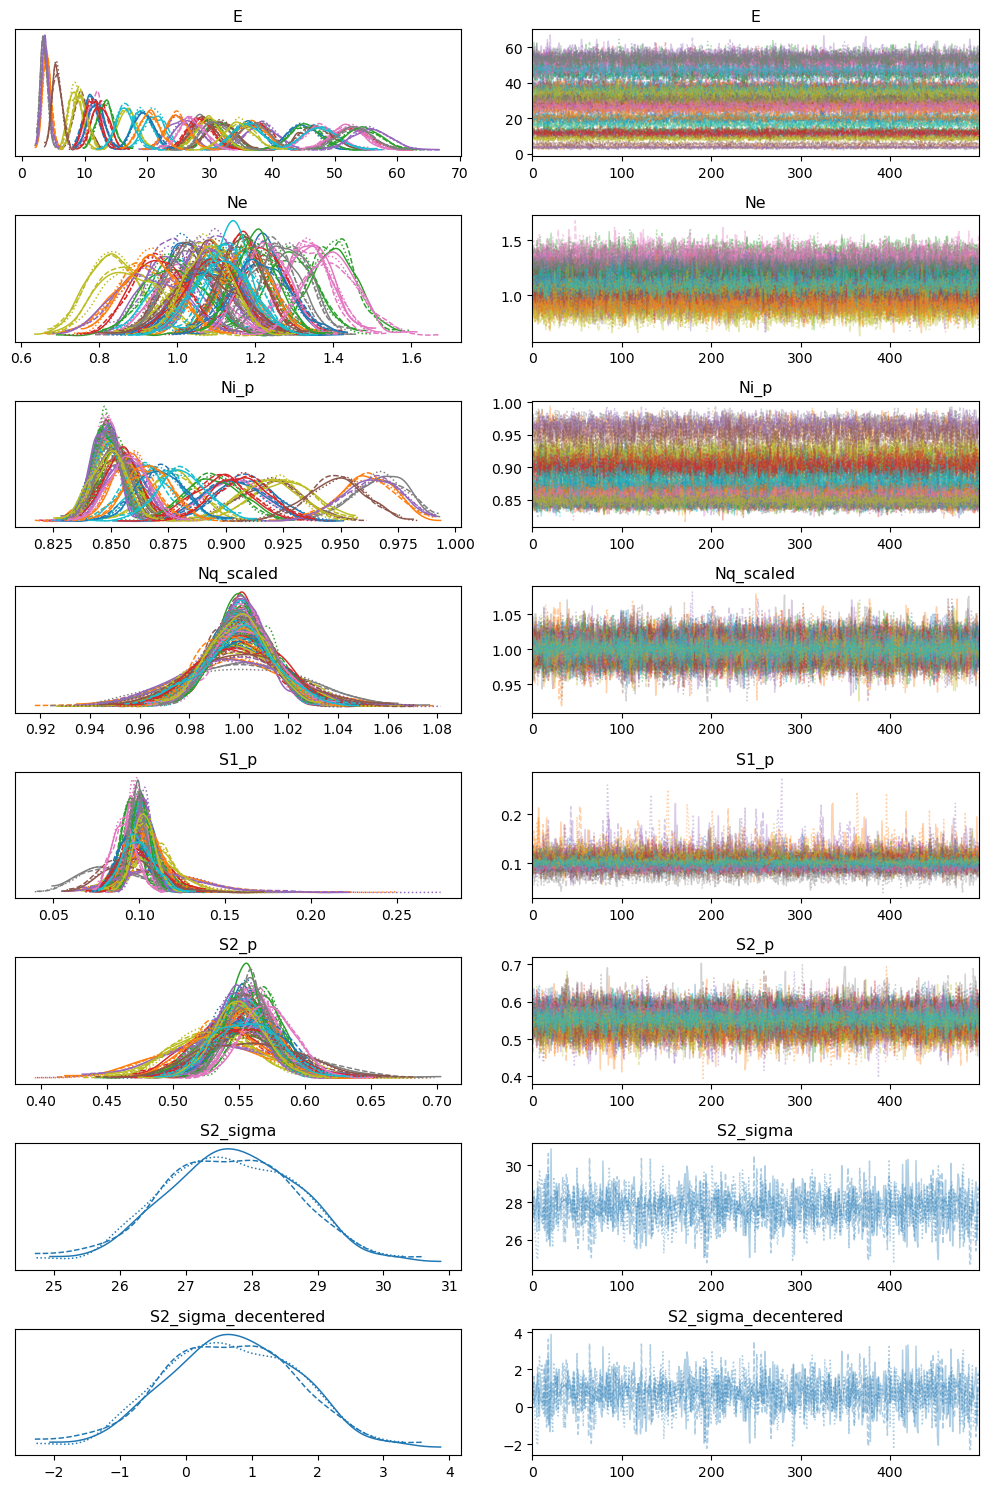

In [42]:
az.plot_trace(inf_data, figsize=(10, 15))
plt.tight_layout()
plt.show()